# 6장. 확률

## 조건부 확률 (conditional probability)

### 아들과 딸 정의

In [ ]:
import enum, random

# An Enum is a typed set of enumerated values. We can use them
# to make our code more descriptive and readable.
class Kid(enum.Enum):
    BOY = 0
    GIRL = 1

### 아들과 딸일 확률을 균등 분포로 샘플링

In [ ]:
def random_kid() -> Kid:
    return random.choice([Kid.BOY, Kid.GIRL])

### 세 종류의 사건 정의

In [ ]:
both_girls = 0 # 사건 B : 두 아이가 모두 딸인 경우
older_girl = 0 # 사건 G : 첫째가 딸인 경우
either_girl = 0 # 사건 L : 최소 한명이 딸인 경우

### 만 번 샘플링을 해서 각 사건에 대해 개수를 셈 

In [ ]:
random.seed(0)

for _ in range(10000):
    younger = random_kid()
    older = random_kid()
    if older == Kid.GIRL:
        older_girl += 1
    if older == Kid.GIRL and younger == Kid.GIRL:
        both_girls += 1
    if older == Kid.GIRL or younger == Kid.GIRL:
        either_girl += 1

print("P(both | older):", both_girls / older_girl)     # 0.514 ~ 1/2
print("P(both | either): ", both_girls / either_girl)  # 0.342 ~ 1/3

assert 0.48 < both_girls / older_girl < 0.52
assert 0.30 < both_girls / either_girl < 0.35

## 연속 분포 (Continuous Distribution)

### 균등 분포

#### 확률 밀도 함수

In [ ]:
def uniform_pdf(x: float) -> float:
    return 1 if 0 <= x < 1 else 0

#### 누적 분포 함수

In [ ]:
def uniform_cdf(x: float) -> float:
    """Returns the probability that a uniform random variable is <= x"""
    if x < 0:   return 0    # uniform random is never less than 0
    elif x < 1: return x    # e.g. P(X <= 0.4) = 0.4
    else:       return 1    # uniform random is always less than 1

### 정규 분포 (Gaussian Distribution)

#### 확률 밀도 함수

In [3]:
import math
SQRT_TWO_PI = math.sqrt(2 * math.pi)

def normal_pdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (math.exp(-(x-mu) ** 2 / 2 / sigma ** 2) / (SQRT_TWO_PI * sigma))

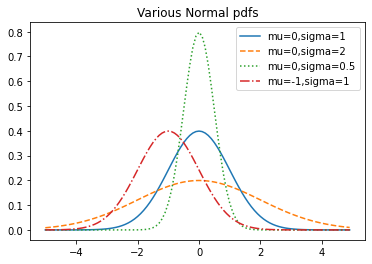

In [4]:
import matplotlib.pyplot as plt
xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs,[normal_pdf(x,sigma=1) for x in xs],'-',label='mu=0,sigma=1')
plt.plot(xs,[normal_pdf(x,sigma=2) for x in xs],'--',label='mu=0,sigma=2')
plt.plot(xs,[normal_pdf(x,sigma=0.5) for x in xs],':',label='mu=0,sigma=0.5')
plt.plot(xs,[normal_pdf(x,mu=-1)   for x in xs],'-.',label='mu=-1,sigma=1')
plt.legend()
plt.title("Various Normal pdfs")
plt.show()

#### 누적 분포 함수

In [5]:
def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

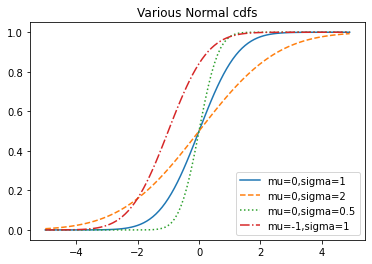

In [6]:
xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs,[normal_cdf(x,sigma=1) for x in xs],'-',label='mu=0,sigma=1')
plt.plot(xs,[normal_cdf(x,sigma=2) for x in xs],'--',label='mu=0,sigma=2')
plt.plot(xs,[normal_cdf(x,sigma=0.5) for x in xs],':',label='mu=0,sigma=0.5')
plt.plot(xs,[normal_cdf(x,mu=-1) for x in xs],'-.',label='mu=-1,sigma=1')
plt.legend(loc=4) # bottom right
plt.title("Various Normal cdfs")
plt.show()

### 정규 분포 누적 확률 분포의 역함수 구하기

In [ ]:
def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

## 중심 극한 정리 (Central Limit Theorem)

### 베르누이 시행

In [7]:
import random

def bernoulli_trial(p: float) -> int:
    """Returns 1 with probability p and 0 with probability 1-p"""
    return 1 if random.random() < p else 0

### 이항 분포

In [9]:
def binomial(n: int, p: float) -> int:
    """Returns the sum of n bernoulli(p) trials"""
    return sum(bernoulli_trial(p) for _ in range(n))

### 이항 분포 반복 시행 후 그래프 확인

In [10]:
from collections import Counter

def binomial_histogram(p: float, n: int, num_points: int) -> None:
    """Picks points from a Binomial(n, p) and plots their histogram"""
    data = [binomial(n, p) for _ in range(num_points)]

    # use a bar chart to show the actual binomial samples
    histogram = Counter(data)
    plt.bar([x - 0.4 for x in histogram.keys()],
            [v / num_points for v in histogram.values()],
            0.8,
            color='0.75')

    mu = p * n
    sigma = math.sqrt(n * p * (1 - p))
    print(mu, sigma)

    # use a line chart to show the normal approximation
    xs = range(min(data), max(data) + 1)
    ys = [normal_cdf(i + 0.5, mu, sigma) - normal_cdf(i - 0.5, mu, sigma)
          for i in xs]
    plt.plot(xs,ys)
    plt.title("Binomial Distribution vs. Normal Approximation")
    plt.show()

75.0 4.330127018922194


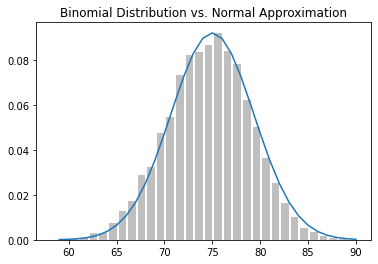

In [16]:
binomial_histogram(0.75, 100, 10000)